<a href="https://colab.research.google.com/github/DineshSiddhartha/SAI_A7/blob/main/STTAI_A7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Logging

In [ ]:
import json
import os

def update_log(dataset_name, train_history, filename="logged_metrics.json"):

    if os.path.exists(filename):
        with open(filename, "r") as f:
            logs = json.load(f)
    else:
        logs = {}

    # Add new dataset log
    logs[dataset_name] = {
        "Training Losses": train_history["train_losses"],
        "Training Accuracies": train_history["train_accuracies"],
        "Validation Losses": train_history["val_losses"],
        "Validation Accuracies": train_history["val_accuracies"],
    }

    # Save updated logs back to file
    with open(filename, "w") as f:
        json.dump(logs, f, indent=4)

Helper code for plotting curves and confusion matrix


In [ ]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score
from torch.utils.tensorboard import SummaryWriter

def plot_confusion_matrix(model, val_loader, device, class_names, writer, task_name):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            data = data.view(data.size(0), -1)
            output = model(data)
            _, predicted = torch.max(output, 1)
            y_true.extend(target.argmax(dim=1).cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)

    # Create figure
    fig, ax = plt.subplots(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")
    ax.set_title(f"Confusion Matrix (Accuracy: {accuracy:.2f})")

    # Show the figure
    plt.show()

    writer.add_figure(f'Confusion Matrix (Task {task_name})', fig, global_step=1)

    # Close figure to free memory
    plt.close(fig)

def evaluate_final_model(model, val_loader, criterion, device, class_names, writer, task_name):
    plot_confusion_matrix(model, val_loader, device, class_names, writer, task_name)


1. Dataset Preparation (10%)

In [ ]:
import pandas as pd

In [ ]:
url = "https://raw.githubusercontent.com/clairett/pytorch-sentiment-classification/master/data/SST2/train.tsv"
df_train = pd.read_csv(url, sep='\t', names=["review", "sentiment"])

print(df_train.head())

                                              review  sentiment
0  a stirring , funny and finally transporting re...          1
1  apparently reassembled from the cutting room f...          0
2  they presume their audience wo n't sit still f...          0
3  this is a visually stunning rumination on love...          1
4  jonathan parker 's bartleby should have been t...          1


In [ ]:
print(df_train.columns)

Index(['review', 'sentiment'], dtype='object')


In [ ]:
url = "https://raw.githubusercontent.com/clairett/pytorch-sentiment-classification/master/data/SST2/test.tsv"
df_test = pd.read_csv(url, sep='\t', names=["review", "sentiment"])

print(df_test.head())

                                              review  sentiment
0       no movement , no yuks , not much of anything          0
1  a gob of drivel so sickly sweet , even the eag...          0
2  gangs of new york is an unapologetic mess , wh...          0
3  we never really feel involved with the story ,...          0
4              this is one of polanski 's best films          1


In [ ]:
url = "https://raw.githubusercontent.com/Ankit152/IMDB-sentiment-analysis/master/IMDB-Dataset.csv"
df_imdb = pd.read_csv(url)

print(df_imdb.head())

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train,X_val,y_train,y_val=train_test_split(df_train['review'],df_train['sentiment'],test_size=0.2,random_state=42)

2. Construct a Multi-Layer Perceptron (MLP) model. (20%)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
class SimpleMLP(nn.Module):
    """
    A simple 3-layer MLP with dropout and batch normalization.

    Architecture:
        Input -> Linear -> BatchNorm -> ReLU -> Dropout ->
        Linear -> BatchNorm -> ReLU -> Dropout ->
        Linear -> Output

    Args:
        input_size (int): Size of input features
        hidden_size (int): Number of neurons in hidden layers
        output_size (int): Number of output classes
    """
    def __init__(self, input_size, hidden_size1,hidden_size2,hidden_size3,hidden_size4, output_size):
        """Initialize a simple 3-layer MLP"""
        super(SimpleMLP, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size1)
        self.layer2 = nn.Linear(hidden_size1, hidden_size2)
        self.layer3 = nn.Linear(hidden_size2, hidden_size3)
        self.layer4 = nn.Linear(hidden_size3, hidden_size4)
        self.layer5 = nn.Linear(hidden_size4, output_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)  # Added dropout for regularization

    def forward(self, x):
        """
        Forward pass of the network.

        Parameters:
        -----------
        x : torch.Tensor
            Input tensor of shape (batch_size, input_size)
            For MNIST/Fashion-MNIST: (batch_size, 784)

        Returns:
        --------
        torch.Tensor
            Output tensor of shape (batch_size, output_size)
            Contains raw logits (pre-softmax)

        Notes:
        ------
        - Input is automatically flattened in the training loop
        - BatchNorm is applied before ReLU as per standard practice
        - Dropout is applied after ReLU to maintain effective regularization
        """
        x = self.dropout(self.relu((self.layer1(x))))
        x = self.dropout(self.relu((self.layer2(x))))
        x = self.dropout(self.relu((self.layer3(x))))
        x = self.dropout(self.relu((self.layer4(x))))
        x = self.layer5(x)
        return x

In [ ]:
import torch
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs, task_name=""):
    """
    Train the model, track performance metrics, and save checkpoint when validation loss decreases.

    Args:
        model (nn.Module): The neural network model
        train_loader (DataLoader): DataLoader for training data
        val_loader (DataLoader): DataLoader for validation data
        criterion: Loss function
        optimizer: Optimization algorithm
        epochs (int): Number of training epochs
        task_name (str): Name of the current task for logging

    Returns:
        dict: Dictionary containing training history (losses, accuracies)
    """
    model.train()
    total_batches = len(train_loader)
    best_val_accuracy = 0  # Track best validation loss


    #TensorBoard writer initialization
    log_dir = f"runs/{task_name}_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}"
    writer = SummaryWriter(log_dir)

    # Logs for tracking performance
    history = {
        'train_losses': [],
        'train_accuracies': [],
        'val_losses': [],
        'val_accuracies': []
    }

    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            data = data.view(data.size(0), -1)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)

            loss.backward()
            optimizer.step()

            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target.argmax(dim=1)).sum().item()

            running_loss += loss.item()

            if batch_idx % 100 == 0:
                batch_accuracy = 100 * correct / total
                print(f'{task_name} - Epoch: {epoch+1}/{epochs}, '
                      f'Batch: {batch_idx}/{total_batches}, '
                      f'Loss: {loss.item():.4f}, '
                      f'Accuracy: {batch_accuracy:.2f}%')

                # Logging training loss & accuracy to TensorBoard
                writer.add_scalar(f"{task_name}/Training Loss", loss.item(), epoch * total_batches + batch_idx)
                writer.add_scalar(f"{task_name}/Training Accuracy", batch_accuracy, epoch * total_batches + batch_idx)

        # Computing epoch-wise training loss & accuracy
        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total

        # Computing validation loss & accuracy
        val_loss, val_accuracy = evaluate_model(model, val_loader, criterion, task_name)

        # Storing logs
        history['train_losses'].append(train_loss)
        history['train_accuracies'].append(train_accuracy)
        history['val_losses'].append(val_loss)
        history['val_accuracies'].append(val_accuracy)

        # Logging epoch-wise metrics to TensorBoard
        writer.add_scalar(f"{task_name}/Epoch Training Loss", train_loss, epoch)
        writer.add_scalar(f"{task_name}/Epoch Training Accuracy", train_accuracy, epoch)
        writer.add_scalar(f"{task_name}/Epoch Validation Loss", val_loss, epoch)
        writer.add_scalar(f"{task_name}/Epoch Validation Accuracy", val_accuracy, epoch)

        # Saving checkpoint if validation loss improves
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy  # Update best loss
            checkpoint = {
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'hyperparameters': {
                    'input_size': input_size,
                    'hidden_size1': hidden_size1,
                    'hidden_size2': hidden_size2,
                    'hidden_size3': hidden_size3,
                    'hidden_size4': hidden_size4,
                    'output_size': output_size,
                },
                'performance': {
                    'val_loss': val_loss,
                    'best_val_accuracy': best_val_accuracy
                },
                'training_history': history  # Saving entire history for logging
            }
            torch.save(checkpoint, f'{task_name}_best_checkpoint_{best_val_accuracy:.4f}.pth')
            print(f"{task_name} checkpoint saved with val_accuracy: {best_val_accuracy:.4f}")


    # Logging Model Architecture
    model_arch = (model)
    writer.add_text("Model Architecture", f"\n{model_arch}\n")
    # Logging hyperparameters to TensorBoard
    writer.add_hparams(
        {
            "initial_lr": initial_lr,
            "transfer_lr": transfer_lr,
            "epochs": epochs,
            "optimiser": "Adam",
            "Number of Batches":total_batches,
        },
        {
            f"{task_name}/Final Validation Accuracy": best_val_accuracy
        }
    )

    writer.close()

    return history


In [ ]:
def evaluate_model(model, val_loader, criterion, task_name=""):
    """
    Compute validation loss and accuracy.

    Args:
        model (nn.Module): Trained model
        val_loader (DataLoader): Validation dataset loader
        criterion: Loss function
        task_name (str): Name of the dataset for logging

    Returns:
        tuple: Validation loss and accuracy
    """
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient computation
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            data = data.view(data.size(0), -1)
            output = model(data)
            loss = criterion(output, target)

            val_loss += loss.item()
            _, predicted = torch.max(output, 1)
            correct += (predicted == target.argmax(dim=1)).sum().item()  # Handle one-hot encoding
            total += target.size(0)

    avg_loss = val_loss / len(val_loader)
    accuracy = 100 * correct / total
    print(f"{task_name} - Validation Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")
    return avg_loss, accuracy


In [ ]:
import matplotlib.pyplot as plt

def plot_training_progress(history, title):
    """
    Plot training & validation loss and accuracy curves.

    Args:
        history (dict): Dictionary containing training and validation metrics
        title (str): Title for the plots

    Returns:
        None. Displays a matplotlib figure with two subplots.
    """
    epochs = range(1, len(history['train_losses']) + 1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Plot Loss
    ax1.plot(epochs, history['train_losses'], 'b-o', label='Train Loss')
    ax1.plot(epochs, history['val_losses'], 'g-s', label='Val Loss')
    ax1.set_title(f'{title} - Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # Plot Accuracy
    ax2.plot(epochs, history['train_accuracies'], 'r-o', label='Train Acc')
    ax2.plot(epochs, history['val_accuracies'], 'c-s', label='Val Acc')
    ax2.set_title(f'{title} - Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()


In [ ]:
# Hyperparameters
input_size = 10000
hidden_size1 = 512
hidden_size2 = 256
hidden_size3 = 128
hidden_size4 = 64
output_size = 2
batch_size = 64
initial_lr = 0.001
transfer_lr = 0.0001
epochs = 10

# Data preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Initialize model and training components
model = SimpleMLP(input_size, hidden_size1,hidden_size2,hidden_size3,hidden_size4, output_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=initial_lr)

print("Model architecture:")
print(model)


Using device: cuda
Model architecture:
SimpleMLP(
  (layer1): Linear(in_features=10000, out_features=512, bias=True)
  (layer2): Linear(in_features=512, out_features=256, bias=True)
  (layer3): Linear(in_features=256, out_features=128, bias=True)
  (layer4): Linear(in_features=128, out_features=64, bias=True)
  (layer5): Linear(in_features=64, out_features=2, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
)


In [ ]:
hyperparameters = {
    "input_size": input_size,
    "hidden_size1": hidden_size1,
    "hidden_size2": hidden_size2,
    "hidden_size3": hidden_size3,
    "hidden_size4": hidden_size4,
    "output_size": output_size,
    "batch_size": batch_size,
    "initial_lr": initial_lr,
    "transfer_lr": transfer_lr,
    "epochs": epochs
}

print("Model Hyperparameters:")
for key, value in hyperparameters.items():
    print(f"{key}: {value}")


Model Hyperparameters:
input_size: 10000
hidden_size1: 512
hidden_size2: 256
hidden_size3: 128
hidden_size4: 64
output_size: 2
batch_size: 64
initial_lr: 0.001
transfer_lr: 0.0001
epochs: 10


In [ ]:
def count_trainable_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

num_params = count_trainable_params(model)

print(f"Total Trainable Parameters: {num_params}")

Total Trainable Parameters: 5293122


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from transformers import AutoTokenizer, AutoModel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np

In [ ]:
def process_bow(train_texts, max_features=10000):
    vectorizer = CountVectorizer(max_features=max_features)
    x = vectorizer.fit_transform(train_texts).toarray()
    return torch.tensor(x, dtype=torch.float32)

In [ ]:
# Combine train and test reviews
all_reviews = list(df_train["review"]) + list(df_test["review"])

# Process combined data
X_all_bow = process_bow(all_reviews)

# Split back into train and test sets
X_train_bow = X_all_bow[:len(df_train)]
X_test_bow = X_all_bow[len(df_train):]


In [ ]:
from tensorflow.keras.utils import to_categorical

y_train_one_hot_bow = to_categorical(df_train['sentiment'], num_classes=2)
y_val_one_hot_bow = to_categorical(y_val, num_classes=2)

In [ ]:
from torch.utils.data import Dataset,DataLoader
import torchvision.datasets as datasets

In [ ]:
class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)  # Convert to tensors
        self.y = torch.tensor(y, dtype=torch.float)  # Convert labels to tensors

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create dataset and DataLoader
train_dataset = TextDataset(X_train_bow, y_train_one_hot_bow)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

<ipython-input-23-fbb32aa4a304>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)  # Convert to tensors


3. Implement case 1: Bag-of-words (20%)

In [ ]:
X_train_bow,X_val_bow,y_train_one_hot_bow,y_val_one_hot_bow=train_test_split(X_train_bow,y_train_one_hot_bow,test_size=0.2,random_state=42)

In [ ]:
X_train_bow.shape

torch.Size([5536, 10000])

In [ ]:
print("X_train_bow shape:", X_train_bow.shape)
print("y_train_one_hot shape:", y_train_one_hot_bow.shape)
print("X_val_bow shape:", X_val_bow.shape)
print("y_val_one_hot shape:", y_val_one_hot_bow.shape)


X_train_bow shape: torch.Size([5536, 10000])
y_train_one_hot shape: (5536, 2)
X_val_bow shape: torch.Size([1384, 10000])
y_val_one_hot shape: (1384, 2)


In [ ]:
val_dataset = TextDataset(X_val_bow, y_val_one_hot_bow)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

<ipython-input-23-fbb32aa4a304>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)  # Convert to tensors


In [ ]:
history1 = train_model(model, train_loader,val_loader, criterion, optimizer, epochs, "BOW")

BOW - Epoch: 1/10, Batch: 0/217, Loss: 0.6934, Accuracy: 43.75%
BOW - Epoch: 1/10, Batch: 100/217, Loss: 0.5400, Accuracy: 62.28%
BOW - Epoch: 1/10, Batch: 200/217, Loss: 0.4964, Accuracy: 68.87%
BOW - Validation Loss: 0.2344, Accuracy: 92.20%
BOW checkpoint saved with val_accuracy: 92.1965
BOW - Epoch: 2/10, Batch: 0/217, Loss: 0.2930, Accuracy: 87.50%
BOW - Epoch: 2/10, Batch: 100/217, Loss: 0.2358, Accuracy: 91.00%
BOW - Epoch: 2/10, Batch: 200/217, Loss: 0.1753, Accuracy: 90.14%
BOW - Validation Loss: 0.0564, Accuracy: 98.92%
BOW checkpoint saved with val_accuracy: 98.9162
BOW - Epoch: 3/10, Batch: 0/217, Loss: 0.1069, Accuracy: 93.75%
BOW - Epoch: 3/10, Batch: 100/217, Loss: 0.0325, Accuracy: 98.51%
BOW - Epoch: 3/10, Batch: 200/217, Loss: 0.0052, Accuracy: 98.48%
BOW - Validation Loss: 0.0083, Accuracy: 99.86%
BOW checkpoint saved with val_accuracy: 99.8555
BOW - Epoch: 4/10, Batch: 0/217, Loss: 0.0052, Accuracy: 100.00%
BOW - Epoch: 4/10, Batch: 100/217, Loss: 0.0009, Accuracy: 

In [ ]:
y_test_one_hot_bow=to_categorical(df_test["sentiment"], num_classes=2)
bow_test_dataset = TextDataset(X_test_bow, y_test_one_hot_bow)
bow_test_loader = DataLoader(bow_test_dataset, batch_size=32, shuffle=True)

<ipython-input-23-fbb32aa4a304>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)  # Convert to tensors


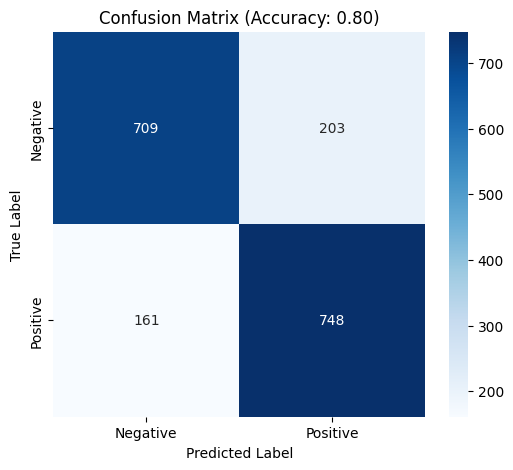

In [ ]:
class_names = ["Negative", "Positive"]  # Adjust according to dataset
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter("runs/conf_matrix")
evaluate_final_model(model, bow_test_loader, criterion, device, class_names, writer,"BOW")

writer.close()

In [ ]:
# Save MNIST checkpoint
checkpoint = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'hyperparameters': {
        'input_size': input_size,
        'hidden_size1': hidden_size1,
        'hidden_size2': hidden_size2,
        'hidden_size3': hidden_size3,
        'hidden_size4': hidden_size4,
        'output_size': output_size,
    },

    'performance': {
        'final_train_loss': history1['train_losses'][-1],
        'final_train_accuracy': history1['train_accuracies'][-1],
        'final_val_loss': history1['val_losses'][-1],
        'final_val_accuracy': history1['val_accuracies'][-1],

    }
}
torch.save(checkpoint, 'BOW_checkpoint.pth')
print("BOW checkpoint saved!")


BOW checkpoint saved!


In [ ]:
update_log('BOW', history1)

In [ ]:
X_imdb_bow = process_bow((np.array(df_imdb["review"]).tolist()))

In [ ]:
from tensorflow.keras.utils import to_categorical
labels = df_imdb["sentiment"].map({"positive": 1, "negative": 0}).tolist()

y_train_one_hot_imdb = to_categorical(labels, num_classes=2)

In [ ]:
X_imdb_bow.shape

torch.Size([50000, 10000])

In [ ]:
X_imdb_train_bow,X_imdb_val_bow,y_imdb_train_one_hot_bow,y_imdb_val_one_hot_bow=train_test_split(X_imdb_bow,y_train_one_hot_imdb,test_size=0.2,random_state=42)

In [ ]:
imdb_train_dataset = TextDataset(X_imdb_train_bow, y_imdb_train_one_hot_bow)
imdb_train_loader = DataLoader(imdb_train_dataset, batch_size=32, shuffle=True)

<ipython-input-23-fbb32aa4a304>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)  # Convert to tensors


In [ ]:
import numpy as np

X_imdb_train_bow = np.array(X_imdb_train_bow, dtype=np.float32)
y_imdb_train_one_hot_bow = np.array(y_imdb_train_one_hot_bow, dtype=np.float32)
X_imdb_val_bow = np.array(X_imdb_val_bow, dtype=np.float32)
y_imdb_val_one_hot_bow = np.array(y_imdb_val_one_hot_bow, dtype=np.float32)


In [ ]:
val_imdb_dataset = TextDataset(X_imdb_val_bow, y_imdb_val_one_hot_bow)
val_imdb_loader = DataLoader(val_imdb_dataset, batch_size=32, shuffle=True)

In [ ]:
# Load checkpoint and prepare for transfer learning
print("\nLoading checkpoint for transfer learning...")
checkpoint = torch.load('BOW_checkpoint.pth')
model.load_state_dict(checkpoint['model_state_dict'])

# Reset optimizer with lower learning rate
optimizer = optim.Adam(model.parameters(), lr=transfer_lr)

print("\nFine-tuning on IMDB Dataset...")
history1_imdb = train_model(model, imdb_train_loader,val_imdb_loader, criterion,
                                                optimizer, epochs, "IMDB_BOW")



Loading checkpoint for transfer learning...

Fine-tuning on IMDB Dataset...
IMDB_BOW - Epoch: 1/10, Batch: 0/1250, Loss: 135.7084, Accuracy: 43.75%
IMDB_BOW - Epoch: 1/10, Batch: 100/1250, Loss: 26.1249, Accuracy: 49.81%
IMDB_BOW - Epoch: 1/10, Batch: 200/1250, Loss: 9.1296, Accuracy: 52.01%
IMDB_BOW - Epoch: 1/10, Batch: 300/1250, Loss: 4.5940, Accuracy: 53.45%
IMDB_BOW - Epoch: 1/10, Batch: 400/1250, Loss: 1.7066, Accuracy: 55.71%
IMDB_BOW - Epoch: 1/10, Batch: 500/1250, Loss: 1.2359, Accuracy: 57.14%
IMDB_BOW - Epoch: 1/10, Batch: 600/1250, Loss: 0.5363, Accuracy: 57.87%
IMDB_BOW - Epoch: 1/10, Batch: 700/1250, Loss: 0.6442, Accuracy: 58.73%
IMDB_BOW - Epoch: 1/10, Batch: 800/1250, Loss: 0.6645, Accuracy: 59.59%
IMDB_BOW - Epoch: 1/10, Batch: 900/1250, Loss: 0.6838, Accuracy: 60.20%
IMDB_BOW - Epoch: 1/10, Batch: 1000/1250, Loss: 0.6392, Accuracy: 61.07%
IMDB_BOW - Epoch: 1/10, Batch: 1100/1250, Loss: 1.0184, Accuracy: 62.01%
IMDB_BOW - Epoch: 1/10, Batch: 1200/1250, Loss: 0.4496, 

In [ ]:
# Save final model
final_checkpoint = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'hyperparameters': {
        'input_size': input_size,
        'hidden_size1': hidden_size1,
        'hidden_size2': hidden_size2,
        'hidden_size3': hidden_size3,
        'hidden_size4': hidden_size4,
        'output_size': output_size,
    },
    'training_history': {
        'initial_task': 'Dataset1',
        'transfer_task': 'IMDB',
        'transfer_learning_rate': transfer_lr,

    'Dataset1_performance': {
        'final_train_loss': history1['train_losses'][-1],
        'final_train_accuracy': history1['train_accuracies'][-1],
        'final_val_loss': history1['val_losses'][-1],
        'final_val_accuracy': history1['val_accuracies'][-1],
    },

    'IMDB_BOW_performance': {
        'final_train_loss': history1_imdb['train_losses'][-1],
        'final_train_accuracy': history1_imdb['train_accuracies'][-1],
        'final_val_loss': history1_imdb['val_losses'][-1],
        'final_val_accuracy': history1_imdb['val_accuracies'][-1],
    }
    }
}
torch.save(final_checkpoint, 'imdb_checkpoint_bow.pth')
print("\nTransfer learning complete! Final model saved.")


Transfer learning complete! Final model saved.


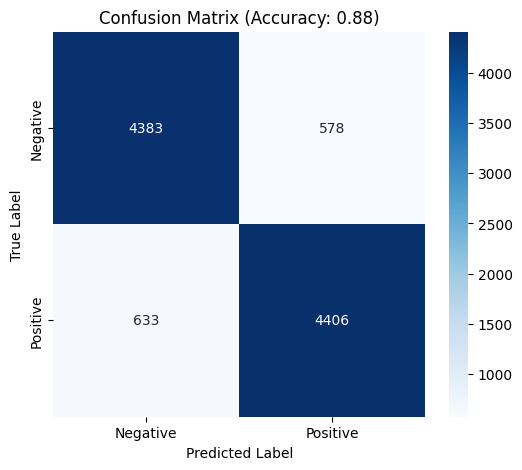

In [ ]:
writer = SummaryWriter("runs/conf_matrix")
evaluate_final_model(model, val_imdb_loader, criterion, device, class_names, writer,"BOW_IMDB")

writer.close()

In [ ]:
update_log('IMDB_BOW', history1_imdb)

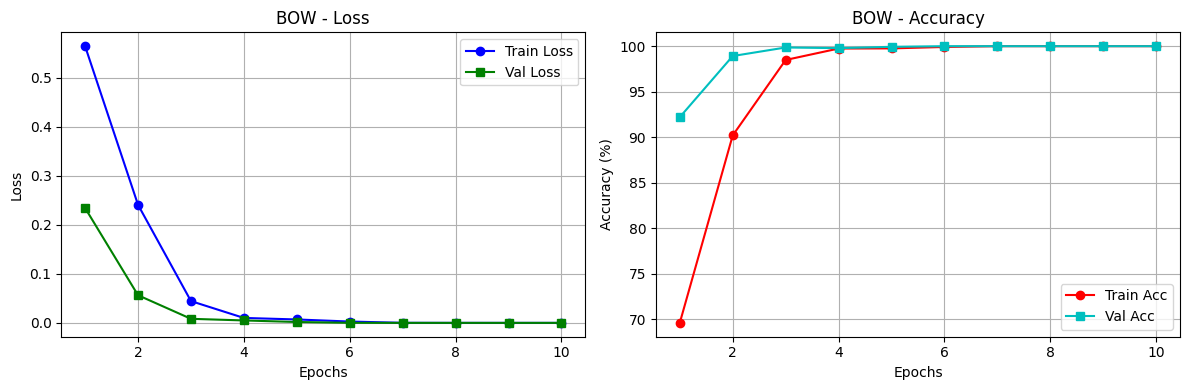

In [ ]:
plot_training_progress(history1, "BOW")

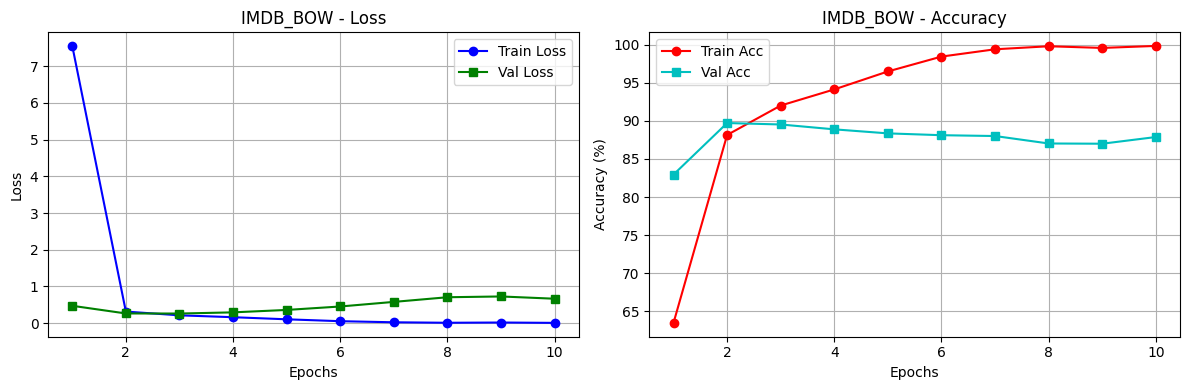

In [ ]:
plot_training_progress(history1_imdb, "IMDB_BOW")

In [ ]:
class EmbeddingModel:
    def __init__(self, model_name="bert-base-uncased", batch_size=32, output_dim=10000):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name).to(device)
        self.batch_size = batch_size
        self.output_dim = output_dim

        if not self.tokenizer.pad_token:
            self.tokenizer.pad_token = "[PAD]"

        self.embedding_size = self.model.config.hidden_size
        self.projection = torch.nn.Linear(self.embedding_size, self.output_dim).to(device) # Projection layer
        self.model_loaded = True

    def get_embeddings(self, texts):
        all_embeddings = []
        for i in range(0, len(texts), self.batch_size):
            batch_texts = texts[i : i + self.batch_size]
            tokens = self.tokenizer(
                batch_texts, padding=True, truncation=True, return_tensors="pt"
            ).to(device)

            with torch.no_grad():
                outputs = self.model(**tokens)

            batch_embeddings = outputs.last_hidden_state[:, 0, :]
            batch_embeddings = self.projection(batch_embeddings)  # Apply projection
            all_embeddings.append(batch_embeddings.cpu())

        return torch.cat(all_embeddings, dim=0)

embedding_model = EmbeddingModel(batch_size=16, output_dim=10000)
X_train_embed = embedding_model.get_embeddings(X_train[:500].tolist())
X_val_embed = embedding_model.get_embeddings(X_val.tolist())


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
# Initialize model and training components
model2 = SimpleMLP(input_size, hidden_size1,hidden_size2,hidden_size3,hidden_size4, output_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=initial_lr)

print("Model architecture:")
print(model2)

Model architecture:
SimpleMLP(
  (layer1): Linear(in_features=10000, out_features=512, bias=True)
  (layer2): Linear(in_features=512, out_features=256, bias=True)
  (layer3): Linear(in_features=256, out_features=128, bias=True)
  (layer4): Linear(in_features=128, out_features=64, bias=True)
  (layer5): Linear(in_features=64, out_features=2, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
)


In [ ]:
def count_trainable_params(model):
    total_params = 0
    print("Trainable Parameters per Layer:")
    for name, param in model.named_parameters():
        if param.requires_grad:
            param_count = param.numel()
            total_params += param_count
            print(f"{name}: {param_count}")

    print(f"\nTotal Trainable Parameters: {total_params}")

# Call the function
count_trainable_params(model)


Trainable Parameters per Layer:
layer1.weight: 5120000
layer1.bias: 512
layer2.weight: 131072
layer2.bias: 256
layer3.weight: 32768
layer3.bias: 128
layer4.weight: 8192
layer4.bias: 64
layer5.weight: 128
layer5.bias: 2

Total Trainable Parameters: 5293122


In [ ]:
y_train_one_hot_embed=y_train_one_hot_bow[:500]
y_val_one_hot_embed=y_val_one_hot_bow

In [ ]:
imdb_embed_train_dataset = TextDataset(X_train_embed, y_train_one_hot_embed)
imdb_embed_train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

<ipython-input-23-fbb32aa4a304>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)  # Convert to tensors


In [ ]:
imdb_embed_val_dataset = TextDataset(X_val_embed, y_val_one_hot_embed)
imdb_embed_val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)

<ipython-input-23-fbb32aa4a304>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)  # Convert to tensors


In [ ]:
history2 = train_model(model, imdb_embed_train_loader,imdb_embed_val_loader, criterion, optimizer, epochs, "BERT_EMBED")

BERT_EMBED - Epoch: 1/10, Batch: 0/109, Loss: 0.1018, Accuracy: 95.31%
BERT_EMBED - Epoch: 1/10, Batch: 100/109, Loss: 0.0000, Accuracy: 99.88%
BERT_EMBED - Validation Loss: 0.0001, Accuracy: 100.00%
BERT_EMBED checkpoint saved with val_accuracy: 100.0000
BERT_EMBED - Epoch: 2/10, Batch: 0/109, Loss: 0.0000, Accuracy: 100.00%
BERT_EMBED - Epoch: 2/10, Batch: 100/109, Loss: 0.0000, Accuracy: 100.00%
BERT_EMBED - Validation Loss: 0.0000, Accuracy: 100.00%
BERT_EMBED - Epoch: 3/10, Batch: 0/109, Loss: 0.0000, Accuracy: 100.00%
BERT_EMBED - Epoch: 3/10, Batch: 100/109, Loss: 0.0000, Accuracy: 100.00%
BERT_EMBED - Validation Loss: 0.0000, Accuracy: 100.00%
BERT_EMBED - Epoch: 4/10, Batch: 0/109, Loss: 0.0000, Accuracy: 100.00%
BERT_EMBED - Epoch: 4/10, Batch: 100/109, Loss: 0.0000, Accuracy: 100.00%
BERT_EMBED - Validation Loss: 0.0000, Accuracy: 100.00%
BERT_EMBED - Epoch: 5/10, Batch: 0/109, Loss: -0.0000, Accuracy: 100.00%
BERT_EMBED - Epoch: 5/10, Batch: 100/109, Loss: 0.0000, Accuracy:

In [ ]:
X_test_embed = embedding_model.get_embeddings(df_test["review"].tolist())

In [ ]:
y_test_one_hot_embed=to_categorical(df_test["sentiment"], num_classes=2)
embed_test_dataset = TextDataset(X_test_embed, y_test_one_hot_embed)
embed_test_loader = DataLoader(embed_test_dataset, batch_size=32, shuffle=True)

<ipython-input-23-fbb32aa4a304>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)  # Convert to tensors


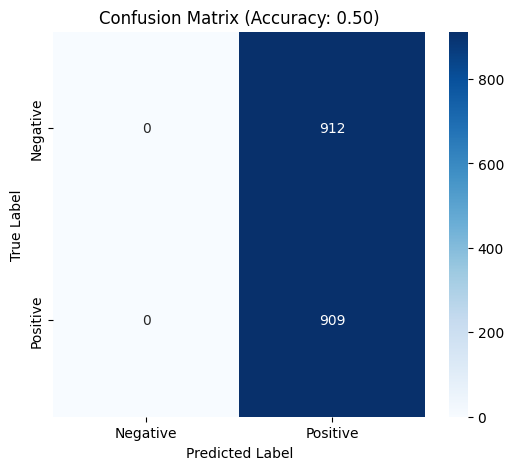

In [ ]:
class_names = ["Negative", "Positive"]  # Adjust according to dataset

writer = SummaryWriter("runs/conf_matrix")
evaluate_final_model(model2, embed_test_loader, criterion, device, class_names, writer,"BERT_EMBED")

writer.close()

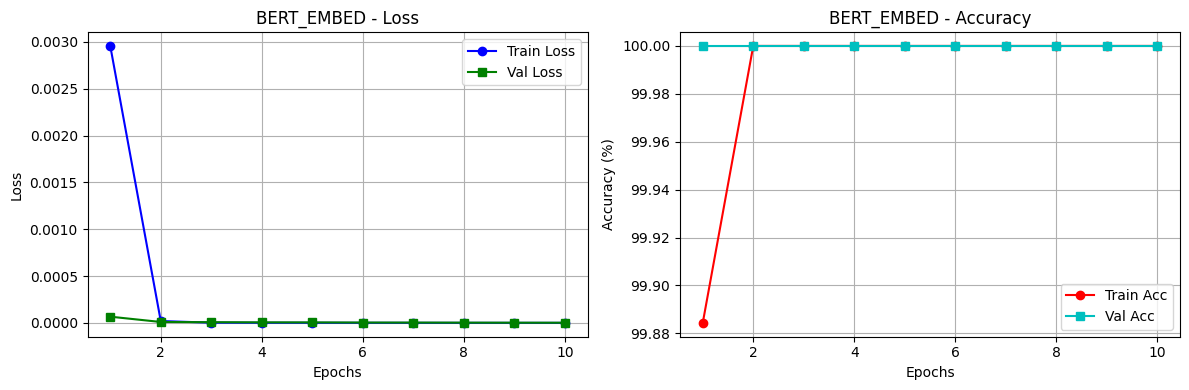

In [ ]:
plot_training_progress(history2, "BERT_EMBED")

In [ ]:
# Save MNIST checkpoint
checkpoint2 = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'hyperparameters': {
        'input_size': input_size,
        'hidden_size1': hidden_size1,
        'hidden_size2': hidden_size2,
        'hidden_size3': hidden_size3,
        'hidden_size4': hidden_size4,
        'output_size': output_size,
    },
    'Dataset2_performance': {
        'final_train_loss': history2['train_losses'][-1],
        'final_train_accuracy': history2['train_accuracies'][-1],
        'final_val_loss': history2['val_losses'][-1],
        'final_val_accuracy': history2['val_accuracies'][-1],

    },
}
torch.save(checkpoint2, 'BERT_EMBED_checkpoint.pth')
print("BERT_EMBED checkpoint saved!")


BERT_EMBED checkpoint saved!


In [ ]:
update_log('BERT_EMBED', history2)

In [ ]:
embedding_model = EmbeddingModel(batch_size=16, output_dim=10000)
X_imdb_embed = embedding_model.get_embeddings(np.array(df_imdb["review"][:500]).tolist())

In [ ]:
labels = df_imdb["sentiment"].map({"positive": 1, "negative": 0}).tolist()
from tensorflow.keras.utils import to_categorical

y_train_one_hot_imdb = to_categorical(labels, num_classes=2)


In [ ]:
X_imdb_embed.shape

torch.Size([500, 10000])

In [ ]:
y_train_one_hot_imdb.shape

(50000, 2)

In [ ]:
X_imdb_train_embed,X_imdb_val_embed,y_imdb_train_one_hot_embed,y_imdb_val_one_hot_embed=train_test_split(X_imdb_embed,y_train_one_hot_imdb[:500],test_size=0.2,random_state=42)

In [ ]:
imdb_train_dataset = TextDataset(X_imdb_train_embed, y_imdb_train_one_hot_embed)
imdb_loader = DataLoader(imdb_train_dataset, batch_size=32, shuffle=True)

<ipython-input-23-fbb32aa4a304>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)  # Convert to tensors


In [ ]:
val_dataset = TextDataset(X_imdb_val_embed, y_imdb_val_one_hot_embed)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

<ipython-input-23-fbb32aa4a304>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)  # Convert to tensors


In [ ]:
print("\nLoading checkpoint for transfer learning...")
checkpoint = torch.load('BERT_EMBED_checkpoint.pth')
model.load_state_dict(checkpoint['model_state_dict'])

# Reset optimizer with lower learning rate
optimizer = optim.Adam(model.parameters(), lr=transfer_lr)

print("\nFine-tuning on IMDB Dataset...")
history2_imdb = train_model(model, imdb_loader,val_loader, criterion,
                                                optimizer, epochs, "IMDB_EMBED")



Loading checkpoint for transfer learning...

Fine-tuning on IMDB Dataset...
IMDB_EMBED - Epoch: 1/10, Batch: 0/13, Loss: 104.2808, Accuracy: 50.00%
IMDB_EMBED - Validation Loss: 0.7445, Accuracy: 60.00%
IMDB_EMBED checkpoint saved with val_accuracy: 60.0000
IMDB_EMBED - Epoch: 2/10, Batch: 0/13, Loss: 1.0342, Accuracy: 59.38%
IMDB_EMBED - Validation Loss: 0.5221, Accuracy: 71.00%
IMDB_EMBED checkpoint saved with val_accuracy: 71.0000
IMDB_EMBED - Epoch: 3/10, Batch: 0/13, Loss: 0.6471, Accuracy: 59.38%
IMDB_EMBED - Validation Loss: 0.4910, Accuracy: 76.00%
IMDB_EMBED checkpoint saved with val_accuracy: 76.0000
IMDB_EMBED - Epoch: 4/10, Batch: 0/13, Loss: 0.4787, Accuracy: 75.00%
IMDB_EMBED - Validation Loss: 0.4769, Accuracy: 72.00%
IMDB_EMBED - Epoch: 5/10, Batch: 0/13, Loss: 0.3995, Accuracy: 75.00%
IMDB_EMBED - Validation Loss: 0.4036, Accuracy: 75.00%
IMDB_EMBED - Epoch: 6/10, Batch: 0/13, Loss: 0.3843, Accuracy: 84.38%
IMDB_EMBED - Validation Loss: 0.4791, Accuracy: 74.00%
IMDB_E

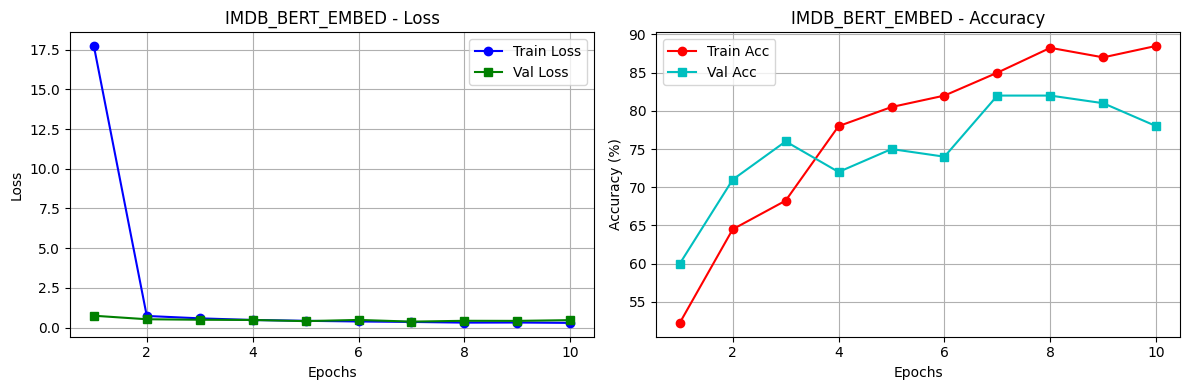

In [ ]:
plot_training_progress(history2_imdb, "IMDB_BERT_EMBED")


In [ ]:
# Save final model
final_checkpoint = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'hyperparameters': {
        'input_size': input_size,
        'hidden_size1': hidden_size1,
        'hidden_size2': hidden_size2,
        'hidden_size3': hidden_size3,
        'hidden_size4': hidden_size4,
        'output_size': output_size,
    },
    'training_history': {
        'initial_task': 'Dataset2',
        'transfer_task': 'IMDB',
        'transfer_learning_rate': transfer_lr,
   'Dataset1_performance': {
        'final_train_loss': history2['train_losses'][-1],
        'final_train_accuracy': history2['train_accuracies'][-1],
        'final_val_loss': history2['val_losses'][-1],
        'final_val_accuracy': history2['val_accuracies'][-1],

    },

    'IMDB_BOW_performance': {
        'final_train_loss': history2_imdb['train_losses'][-1],
        'final_train_accuracy': history2_imdb['train_accuracies'][-1],
        'final_val_loss': history2_imdb['val_losses'][-1],
        'final_val_accuracy': history2_imdb['val_accuracies'][-1],

    }
    }
}
torch.save(final_checkpoint, 'imdb_bert_embed.pth')
print("\nTransfer learning complete! Final model saved.")


Transfer learning complete! Final model saved.


In [ ]:
update_log('IMDB_Dataset2', history2_imdb)

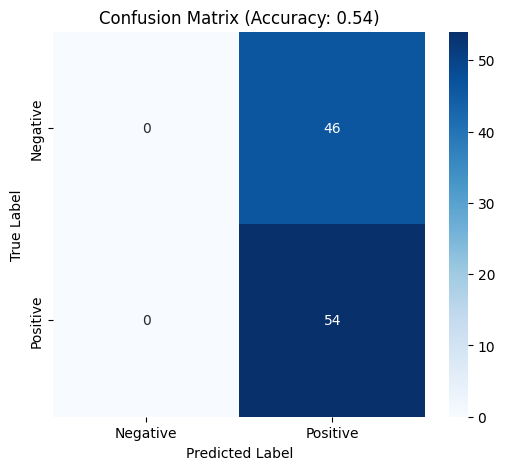

In [ ]:
class_names = ["Negative", "Positive"]  # Adjust according to dataset

writer = SummaryWriter("runs/conf_matrix")
evaluate_final_model(model2, val_loader, criterion, device, class_names, writer,"BERT_EMBED_IMDB")

writer.close()

In [ ]:
# Function to log model parameters
def log_model_parameters(model):
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f"{name}: {param.shape}")
log_model_parameters(model)


layer1.weight: torch.Size([512, 10000])
layer1.bias: torch.Size([512])
layer2.weight: torch.Size([256, 512])
layer2.bias: torch.Size([256])
layer3.weight: torch.Size([128, 256])
layer3.bias: torch.Size([128])
layer4.weight: torch.Size([64, 128])
layer4.bias: torch.Size([64])
layer5.weight: torch.Size([2, 64])
layer5.bias: torch.Size([2])


In [ ]:
log_model_parameters(model2)


layer1.weight: torch.Size([512, 10000])
layer1.bias: torch.Size([512])
layer2.weight: torch.Size([256, 512])
layer2.bias: torch.Size([256])
layer3.weight: torch.Size([128, 256])
layer3.bias: torch.Size([128])
layer4.weight: torch.Size([64, 128])
layer4.bias: torch.Size([64])
layer5.weight: torch.Size([2, 64])
layer5.bias: torch.Size([2])


In [ ]:
print("Model Hyperparameters:")
for key, value in hyperparameters.items():
    print(f"{key}: {value}")


Model Hyperparameters:
input_size: 10000
hidden_size1: 512
hidden_size2: 256
hidden_size3: 128
hidden_size4: 64
output_size: 2
batch_size: 64
initial_lr: 0.001
transfer_lr: 0.0001
epochs: 10


Tensorboard Integration

In [ ]:
%load_ext tensorboard


In [ ]:
%tensorboard --logdir runs


Model architecture.

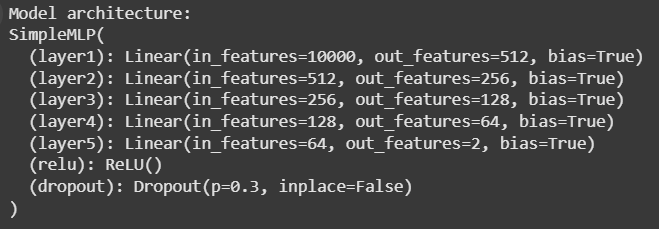

Hyperparameters

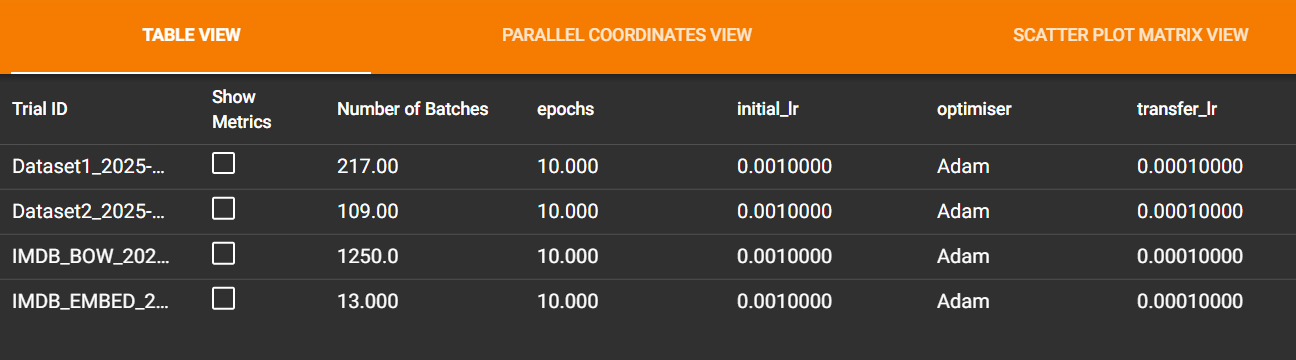

Logged metrics.

In [ ]:
import json
from tabulate import tabulate

file_path = "/content/logged_metrics.json"

with open(file_path, "r") as file:
    data = json.load(file)

# Print as table
for dataset, metrics in data.items():
    print(f"\nDataset: {dataset}\n")
    keys = list(metrics.keys())
    headers = ["Epoch"] + keys

    table = []
    for i in range(len(metrics[keys[0]])):
        row = [i + 1] + [metrics[key][i] for key in keys]
        table.append(row)

    print(tabulate(table, headers=headers, tablefmt="grid"))



Dataset: BOW

+---------+-------------------+-----------------------+---------------------+-------------------------+
|   Epoch |   Training Losses |   Training Accuracies |   Validation Losses |   Validation Accuracies |
+=========+===================+=======================+=====================+=========================+
|       1 |       0.564583    |               69.5809 |         0.234402    |                 92.1965 |
+---------+-------------------+-----------------------+---------------------+-------------------------+
|       2 |       0.240882    |               90.1879 |         0.056398    |                 98.9162 |
+---------+-------------------+-----------------------+---------------------+-------------------------+
|       3 |       0.0444527   |               98.4827 |         0.00831424  |                 99.8555 |
+---------+-------------------+-----------------------+---------------------+-------------------------+
|       4 |       0.0100949   |               99.

Final evaluation results

Dataset1 - Validation Loss: 0.0000, Accuracy: 100.00%        
IMDB_BOW - Validation Loss: 0.6633, Accuracy: 87.89%          
Dataset2 - Validation Loss: 0.0001, Accuracy: 100.00%               
IMDB_EMBED - Validation Loss: 0.3578, Accuracy: 82.00%     



Confusion matrix visualization.
Training and validation loss curves.



Plotted above

checkpoint compression

I have not saved all model weights after each training epoch but have saved the model only when the validation accuracy increased from the previous best accuracy. This will help reducing storage.

TensorBoard integration